In [1]:
from utils import *

In [2]:
json_path = r'data/catchments_long.json'
catchment_dict_list = long_json_to_list(json_path)

In [3]:
demo_catchment = catchment_dict_list[0]

grid_by_num_splits = corners_to_grid_by_num_splits(demo_catchment, 100)

In [4]:
api_response = elevation_api_caller(grid_by_num_splits)

In [5]:
elevation_grid_by_num_splits = parse_api_resonse_to_dataframe(api_response)

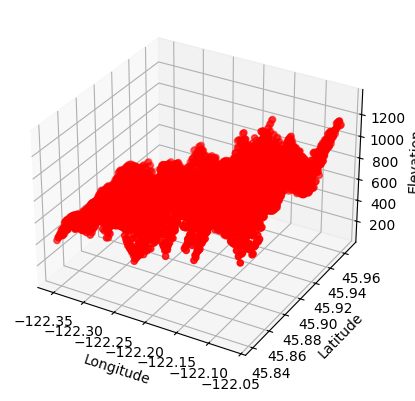

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with elevation as height
ax.scatter(elevation_grid_by_num_splits['longitude'], elevation_grid_by_num_splits['latitude'], elevation_grid_by_num_splits['elevation'], c='r', marker='o')

# Set labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Elevation')

# Show the plot
plt.show()

In [27]:
import plotly.express as px

fig = px.scatter_3d(elevation_grid_by_num_splits, x='longitude', y='latitude', z='elevation', title='Elevation 3D Scatter Plot')

# Show the plot
fig.show()

In [28]:
import plotly.graph_objects as go
import numpy as np
z = np.array(elevation_grid_by_num_splits['elevation'])
x = np.array(elevation_grid_by_num_splits['latitude'])
y = np.array(elevation_grid_by_num_splits['longitude'])


#fig = go.Figure(data=[go.Surface(z=elevation_grid_by_num_splits.values[2], x=elevation_grid_by_num_splits.values[0], y=elevation_grid_by_num_splits.values[1])])

fig = go.Figure(data=[go.Surface(z=elevation_grid_by_num_splits['elevation'],
                                x=elevation_grid_by_num_splits['latitude'],
                                y=elevation_grid_by_num_splits['longitude'])])


fig.update_layout(
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.7),
        aspectmode='manual',
        xaxis=dict(range=[elevation_grid_by_num_splits.values[0].min(), elevation_grid_by_num_splits.values[0].max()]),
        yaxis=dict(range=[elevation_grid_by_num_splits.values[1].min(), elevation_grid_by_num_splits.values[1].max()]),
        zaxis=dict(range=[elevation_grid_by_num_splits.values[2].min(), elevation_grid_by_num_splits.values[2].max()])
    )
)

fig.show()

In [29]:
test_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')